In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [52]:
data_complete = pd.read_csv('./super_data.csv')
data = data_complete[data_complete.columns[2:]].drop(['YEAR'], axis=1)
data['PH'] = data['PH'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4566 entries, 0 to 4565
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PH      4559 non-null   float64
 1   EC      4561 non-null   float64
 2   ALK     4559 non-null   float64
 3   SO4     4559 non-null   float64
 4   CO3     4554 non-null   float64
 5   F       4559 non-null   float64
 6   MG      4559 non-null   float64
 7   HCO3    4559 non-null   float64
 8   TDS     4559 non-null   float64
 9   NO3     4559 non-null   float64
 10  TH      4558 non-null   float64
 11  CL      4559 non-null   float64
 12  NA      4558 non-null   float64
 13  CA      4558 non-null   float64
 14  K       4558 non-null   float64
dtypes: float64(15)
memory usage: 535.2 KB


## :sparkles: CCME-WQI

In [53]:
drinking_water_range = {
    # "Component": [Acceptable Limit, Permissible Limit in absence of alternative source]
    "PH": [6.5, 8.5], #
    "EC": [0, 1500], #
    "TDS": [500, 2000], #
    "ALK": [200, 600], #
    "TH": [200, 600], #
    "CL": [250, 1000], #
    "CA": [75, 200], #
    "MG": [30, 100], #
    "SO4": [200, 400], #
    "NO3": [0, 45], #
    "F": [1, 1.5], #
}

In [54]:
import numpy as np

features = drinking_water_range.keys()
total_number_of_features = len(features)

def calculate_F1(df, guideline_values):
    F1 = sum(1 for feature in features if df[feature] < guideline_values[feature][0] or df[feature] > guideline_values[feature][1])
    return (F1*100)/total_number_of_features


def calculate_F2(df, guideline_values):
    F2 = sum(1 for feature in features if df[feature] > guideline_values[feature][1])
    return (F2*100)/total_number_of_features


def calculate_F3(df, guideline_values):
    F3_list = []
    for feature in features:
        F3 = 0
        if df[feature] < guideline_values[feature][0]:
            F3 = (guideline_values[feature][0] - df[feature])/guideline_values[feature][0]
        elif df[feature] > guideline_values[feature][1]:
            F3 = (df[feature] - guideline_values[feature][1])/guideline_values[feature][1]
        F3_list.append(F3)
    nse = sum(F3_list)/len(features)
    return nse/(0.01*nse + 0.01)


def calculate_WQI(df, guideline_values):
    wqi_values = []
    for idx, row in df.iterrows():
        F1 = calculate_F1(df.iloc[idx], guideline_values)
        F2 = calculate_F2(df.iloc[idx], guideline_values)
        F3 = calculate_F3(df.iloc[idx], guideline_values)
        wqi = (np.sqrt(F1*F1 + F2*F2 + F3*F3) / 1.732)  # Dividing by 1.732 to reduce the value to 100
        wqi_values.append(wqi)
    return wqi_values


# Calculating WQI for each instance
wqi_values = calculate_WQI(data, drinking_water_range)
# Adding WQI values to DataFrame
results = pd.DataFrame()
results['CCME-WQI'] = wqi_values
results['CCME-WQI'] = results['CCME-WQI'].apply(lambda x: np.abs(100-x))

In [55]:
results['CCME-WQI']

0       61.555420
1       64.601738
2       69.023569
3       76.746451
4       29.843938
          ...    
4561    60.989717
4562    57.180425
4563    75.149894
4564    87.842858
4565    77.998531
Name: CCME-WQI, Length: 4566, dtype: float64

## :sparkles: WAWQI

In [56]:
constants = pd.DataFrame({
    'features':        ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG'],
    'standard_values': [8.5 , 300, 1000,  120, 300, 1.5, 250,  45,  250,  75,  30],
    'ideal_values':    [    7,  0,    0,    0,   0,   0,   0,   0,    0,   0,   0],
})

In [57]:
def calculate_K():
    return 1/(constants['standard_values'].sum())

def calculate_qi_wi(df):
    qn = pd.DataFrame()
    qi_wi = []
    Wn = calculate_unit_weight_of_nth_parameter()

    for col in constants['features']:
        v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
        s_value = constants[constants['features'] == col]['standard_values'].values[0]
        qn[col] = 100 * ((df[col] - v_ideal) / (s_value - v_ideal))

    for row in qn.iterrows():
        qi_wi.append((np.array(row[1])*Wn).sum())
    
    qn['qi_wi'] = qi_wi

    return qn

def calculate_unit_weight_of_nth_parameter():
    Wn = []
    K = calculate_K()
    for feature in features:
        Wn.append(K/constants[constants['features'] == feature]['standard_values'])
    constants['unit_weights'] = Wn
    return Wn

def calculate_wawqi(data):
    Wn = calculate_unit_weight_of_nth_parameter()
    qn = calculate_qi_wi(data)

    wawqi = qn['qi_wi'] / np.array(Wn).sum()
    return wawqi/100

wawqi = calculate_wawqi(data)

In [58]:
results['WAWQI'] = wawqi

In [59]:
results

,CCME-WQI,WAWQI
0,61.555420,38.644111
1,64.601738,8.988333
2,69.023569,22.555222
3,76.746451,14.035111
4,29.843938,103.398000
...,...,...
4561,60.989717,7.274778
4562,57.180425,34.582556
4563,75.149894,23.527667
4564,87.842858,15.582556


## :sparkles: EBWQI

In [60]:
from sklearn.preprocessing import MinMaxScaler

# data = data.drop(['DISTRICT','YEAR','LOCATION'], axis=1).reset_index(drop=True)
data = data.reset_index(drop=True)

scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data = pd.DataFrame(scaled_data, columns=data.columns)
scaled_data

,PH,EC,ALK,SO4,CO3,F,MG,HCO3,TDS,NO3,TH,CL,NA,CA,K
0,0.008383,0.088537,0.441708,0.122183,0.0,0.040625,0.012223,0.467816,0.087319,0.010625,0.051877,0.031796,0.125323,0.019608,0.000667
1,0.008221,0.014630,0.109195,0.029656,0.0,0.027500,0.002546,0.120295,0.013312,0.007500,0.017084,0.001481,0.016989,0.010893,0.028667
2,0.008647,0.047222,0.252874,0.019375,0.0,0.003125,0.018335,0.270489,0.045970,0.010000,0.064055,0.018675,0.050966,0.013072,0.061667
3,0.008521,0.027630,0.137931,0.021352,0.0,0.021875,0.007894,0.150193,0.026348,0.010625,0.036220,0.007569,0.025606,0.015251,0.008667
4,0.008434,0.268889,0.404762,0.189008,0.0,0.038750,0.055004,0.429124,0.267907,0.028125,0.234543,0.179096,0.361689,0.095861,0.055000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,0.008045,0.014222,0.051724,0.043100,0.0,0.001875,0.004838,0.060148,0.012925,0.002000,0.031001,0.004360,0.011449,0.019608,0.016667
4562,0.008434,0.081833,0.125616,0.137999,0.0,0.009750,0.028520,0.137531,0.080621,0.008125,0.121638,0.043478,0.087406,0.050109,0.028333
4563,0.008271,0.054481,0.084565,0.228153,0.0,0.011625,0.004329,0.094618,0.053222,0.020625,0.069274,0.023035,0.067709,0.069717,0.043333
4564,0.007957,0.027111,0.195402,0.025306,0.0,0.013000,0.009167,0.210341,0.025822,0.000194,0.071014,0.005553,0.015142,0.054466,0.030000


In [61]:
import numpy as np

# calculate entropy weight and information entropy for entropy water quality index
def information_entropy(df):
    # calculate information entropy
    information_entropy_arr = {}
    for i in range(len(df.columns)):
        p = df.iloc[:,i]/df.iloc[:,i].sum()
        entropy = - (p * np.log(p)/np.log(len(df))).sum()
        information_entropy_arr[df.columns.to_list()[i]] = entropy
    return information_entropy_arr

def entropy_weight(df):
    # calculate entropy weight
    information_entropy_arr_res = information_entropy(df)
    information_entropy_arr = np.array(list(information_entropy_arr_res.values()))
    # print(information_entropy_arr_res)
    information_entropy_arr_sum = np.sum(1 - information_entropy_arr)
    information_entropy_arr_res_df = pd.DataFrame({
        'features': list(information_entropy_arr_res.keys()),
        'information_entropy': list(information_entropy_arr_res.values())
    })
    # print(information_entropy_arr_res_df)
    information_entropy_arr_res_df['entropy_weights'] = (1 - information_entropy_arr_res_df['information_entropy'])/information_entropy_arr_sum
    # print(information_entropy_arr_res_df)
    return information_entropy_arr_res_df

entropy_weight_arr = entropy_weight(scaled_data[constants['features']])
entropy_weight_arr

,features,information_entropy,entropy_weights
0,PH,0.988699,0.020064
1,EC,0.950484,0.087912
2,TDS,0.947134,0.093858
3,ALK,0.980946,0.033829
4,TH,0.958217,0.074182
5,F,0.942822,0.101516
6,CL,0.899062,0.179207
7,NO3,0.922581,0.137451
8,SO4,0.953831,0.081969
9,CA,0.952911,0.083603


In [62]:
constants['weights'] = entropy_weight_arr['entropy_weights'].to_list()
constants

,features,standard_values,ideal_values,unit_weights,weights
0,PH,8.5,7,"0 0.000049 Name: standard_values, dtype: fl...",0.020064
1,EC,300.0,0,"1 0.000001 Name: standard_values, dtype: fl...",0.087912
2,TDS,1000.0,0,"2 4.201681e-07 Name: standard_values, dtype...",0.093858
3,ALK,120.0,0,"3 0.000004 Name: standard_values, dtype: fl...",0.033829
4,TH,300.0,0,"4 0.000001 Name: standard_values, dtype: fl...",0.074182
5,F,1.5,0,"6 0.000002 Name: standard_values, dtype: fl...",0.101516
6,CL,250.0,0,"9 0.000006 Name: standard_values, dtype: fl...",0.179207
7,NO3,45.0,0,"10 0.000014 Name: standard_values, dtype: f...",0.137451
8,SO4,250.0,0,"8 0.000002 Name: standard_values, dtype: fl...",0.081969
9,CA,75.0,0,"7 0.000009 Name: standard_values, dtype: fl...",0.083603


In [63]:
import numpy as np

qe = pd.DataFrame()
qi_wi = []

for col in constants['features']:
    # print('col = ', col)
    v_ideal = constants[constants['features'] == col]['ideal_values'].values[0]
    s_value = constants[constants['features'] == col]['standard_values'].values[0]
    # print(v_ideal, s_value)
    qe[col] = 100 * (data[col] - v_ideal) / (s_value - v_ideal)

for row in qe.iterrows():
    qi_wi.append((np.array(row[1])*constants['weights']).sum())

qe

,PH,EC,TDS,ALK,TH,F,CL,NO3,SO4,CA,MG
0,46.000000,1593.666667,320.3,916.666667,100.000000,216.666667,312.0,37.777778,108.0,53.333333,160.000000
1,37.333333,263.333333,52.9,241.666667,33.333333,146.666667,17.2,26.666667,14.4,32.000000,33.333333
2,60.000000,850.000000,170.9,533.333333,123.333333,16.666667,184.4,35.555556,4.0,37.333333,240.000000
3,53.333333,497.333333,100.0,300.000000,70.000000,116.666667,76.4,37.777778,6.0,42.666667,103.333333
4,48.666667,4840.000000,972.8,841.666667,450.000000,206.666667,1744.4,100.000000,175.6,240.000000,720.000000
...,...,...,...,...,...,...,...,...,...,...,...
4561,28.000000,256.000000,51.5,125.000000,60.000000,10.000000,45.2,7.111111,28.0,53.333333,63.333333
4562,48.666667,1473.000000,296.1,275.000000,233.666667,52.000000,425.6,28.888889,124.0,128.000000,373.333333
4563,40.000000,980.666667,197.1,191.666667,133.333333,62.000000,226.8,73.333333,215.2,176.000000,56.666667
4564,23.333333,488.000000,98.1,416.666667,136.666667,69.333333,56.8,0.688889,10.0,138.666667,120.000000


In [64]:
qe['qi_wi'] = qi_wi
results['EBWQI'] = qe['qi_wi'] / constants['weights'].sum()
results

,CCME-WQI,WAWQI,EBWQI
0,61.555420,38.644111,322.953062
1,64.601738,8.988333,68.551642
2,69.023569,22.555222,187.772599
3,76.746451,14.035111,115.300810
4,29.843938,103.398000,1038.036172
...,...,...,...
4561,60.989717,7.274778,60.166415
4562,57.180425,34.582556,331.010335
4563,75.149894,23.527667,217.290519
4564,87.842858,15.582556,119.304083


(0.0, 1000.0)

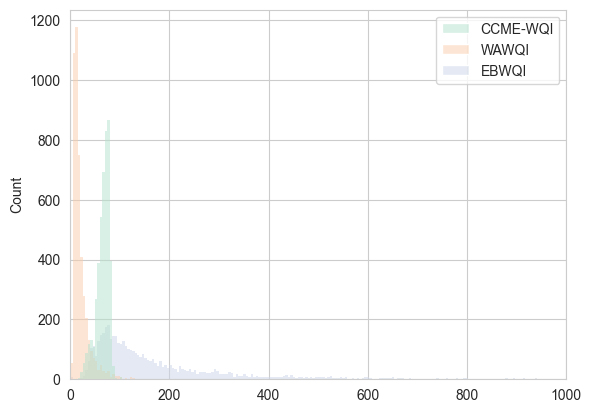

In [65]:
sns.histplot(results)
sns.set_palette('Pastel2')
plt.xlim(0, 1000)

In [66]:
results.to_csv("wqi_results.csv", index=False)

## Regression

In [67]:
# import all other regression models available in different libraries
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# import metrics to evaluate the models
from sklearn.model_selection import cross_val_score, KFold

In [68]:
# create a dictionary for model names and model objects

models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'Elastic Net': ElasticNet(),
    'K Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Support Vector Machine': SVR(),
    'Ada Boost': AdaBoostRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'Extra Trees': ExtraTreesRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gaussian Process': GaussianProcessRegressor(),
    'Kernel Ridge': KernelRidge(),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=False),
    'LightGBM': LGBMRegressor(),
    'Multi Layer Perceptron': MLPRegressor()
}

In [69]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def correlation_coefficient(observed, predicted):
    return np.corrcoef(observed, predicted)[0, 1]

def root_mean_square_error(observed, predicted):
    return np.sqrt(mean_squared_error(observed, predicted))

def nash_sutcliffe_efficiency(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    return 1 - (numerator / denominator)

def index_of_agreement(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((np.abs(predicted - mean_observed) +
                          np.abs(observed - mean_observed)) ** 2)
    return 1 - (numerator / denominator)

In [71]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

k_folds = 5  # You can adjust the number of folds as needed
kf = KFold(n_splits=k_folds)

wqi = pd.concat([data, results], axis=1)
wqi = wqi.dropna()
features = ['PH','EC','TDS','ALK','TH', 'F','CL','NO3','SO4','CA','MG']

X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

X_train, X_test, y1_train, y1_test, y2_train, y2_test, y3_train, y3_test = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

# Create a dictionary to store results
results_dict = {'Model': [], 'Target': [], 'Metric': [], 'Metric Value': [], 'y_test': [], 'y_pred': []}

# Metrics to calculate
metrics = {
    'MSE': mean_squared_error,
    'RMSE': lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    'MAE': mean_absolute_error,
    'R2': r2_score,
    'NSE': lambda y_true, y_pred: 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
}

# Loop through models
for name, model in tqdm(models.items()):
    for target_name, target_train, target_test in [('WAWQI', y1_train, y1_test), ('EBWQI', y2_train, y2_test), ('CCME-WQI', y3_train, y3_test)]:
        for metric_name, metric_func in metrics.items():
            metric_values = []  # Store metric values for each fold
            for train_index, val_index in kf.split(target_train):
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = target_train.iloc[train_index], target_train.iloc[val_index]

                # Train the model
                model.fit(X_train_fold, y_train_fold)

                # Predict on the validation set
                y_val_pred = model.predict(X_val_fold)

                # Calculate the metric value for this fold
                fold_metric_value = metric_func(y_val_fold, y_val_pred)
                metric_values.append(fold_metric_value)

            # Average the metric values across folds
            average_metric_value = sum(metric_values) / len(metric_values)

            # Train the model on the entire training set
            model.fit(X_train, target_train)

            # Predict on the test set
            y_pred = model.predict(X_test)

            # Calculate the metric value on the test set
            test_metric_value = metric_func(target_test, y_pred)

            # Store results in the dictionary
            results_dict['Model'].append(name)
            results_dict['Target'].append(target_name)
            results_dict['Metric'].append(metric_name)
            results_dict['Metric Value'].append(test_metric_value)
            results_dict['y_test'].append(target_test)
            results_dict['y_pred'].append(y_pred)

            # # Train the model
            # model.fit(X_train, target_train)

            # # Predict on the test set
            # y_pred = model.predict(X_test)

            # # Calculate the metric value
            # metric_value = metric_func(target_test, y_pred)

            # # Store results in the dictionary
            # results_dict['Model'].append(name)
            # results_dict['Target'].append(target_name)
            # results_dict['Metric'].append(metric_name)
            # results_dict['Metric Value'].append(metric_value)
            # results_dict['y_test'].append(target_test)
            # results_dict['y_pred'].append(y_pred)


# Create a DataFrame
regression_results_df = pd.DataFrame(results_dict)

# Pivot the DataFrame
comparison_df_reg = regression_results_df.pivot(index='Target', columns=['Metric','Model'], values='Metric Value')

# Print the comparison DataFrame
comparison_df_reg.style.background_gradient(cmap='Greens', axis=None)

  0%|          | 0/17 [00:00<?, ?it/s]

 71%|███████   | 12/17 [31:47<13:14, 158.99s/it]


KeyboardInterrupt: 

In [ ]:
# fig, axes = plt.subplots(3, 1, figsize=(20, 40))
# sns.set_style('whitegrid')
# sns.set_palette('Paired')
# for ax, metric in zip(axes.flatten(), ['MSE','RMSE','R2']):
#     sns.barplot(data=regression_results_df[regression_results_df['Metric'] == metric].sort_values(by="Metric Value", ascending=False), x='Metric Value', y='Model', hue='Target', ax=ax, orient='h', palette='Paired')

In [22]:
regression_results_df[regression_results_df['Metric'] == 'R2'].sort_values(by='Metric Value', ascending=False).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
3,Linear Regression,WAWQI,R2,1.000000,472 53.659444 2531 18.042417 23 12...,"[53.65944444444448, 18.04241666666666, 12.5118..."
8,Linear Regression,EBWQI,R2,1.000000,472 537.320129 2531 163.885568 23 ...,"[537.3201289016931, 163.88556808494434, 101.60..."
23,Ridge,EBWQI,R2,0.999987,472 537.320129 2531 163.885568 23 ...,"[537.2795404009298, 163.90318689684258, 101.60..."
18,Ridge,WAWQI,R2,0.999982,472 53.659444 2531 18.042417 23 12...,"[53.653484356678476, 18.040929810696742, 12.51..."
243,Multi Layer Perceptron,WAWQI,R2,0.999852,472 53.659444 2531 18.042417 23 12...,"[53.272382397249295, 18.28775584813588, 12.484..."
38,Lasso,EBWQI,R2,0.999678,472 537.320129 2531 163.885568 23 ...,"[536.0696690356423, 164.98173151635086, 102.08..."
248,Multi Layer Perceptron,EBWQI,R2,0.999417,472 537.320129 2531 163.885568 23 ...,"[533.2808990784216, 174.2189150483819, 96.5625..."
223,CatBoost,CCME-WQI,R2,0.995814,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
128,Gradient Boosting,EBWQI,R2,0.994204,472 537.320129 2531 163.885568 23 ...,"[525.8887356440376, 168.32914036140653, 97.446..."
213,CatBoost,WAWQI,R2,0.993982,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."


In [23]:
regression_results_df[regression_results_df['Metric'] == 'MSE'].sort_values(by='Metric Value', ascending=True).head(10)

,Model,Target,Metric,Metric Value,y_test,y_pred
0,Linear Regression,WAWQI,MSE,3.326155e-28,472 53.659444 2531 18.042417 23 12...,"[53.65944444444448, 18.04241666666666, 12.5118..."
5,Linear Regression,EBWQI,MSE,1.768587e-26,472 537.320129 2531 163.885568 23 ...,"[537.3201289016931, 163.88556808494434, 101.60..."
15,Ridge,WAWQI,MSE,6.897113e-03,472 53.659444 2531 18.042417 23 12...,"[53.653484356678476, 18.040929810696742, 12.51..."
240,Multi Layer Perceptron,WAWQI,MSE,5.953793e-02,472 53.659444 2531 18.042417 23 12...,"[53.59765783592049, 18.462109588975466, 12.323..."
20,Ridge,EBWQI,MSE,5.340165e-01,472 537.320129 2531 163.885568 23 ...,"[537.2795404009298, 163.90318689684258, 101.60..."
220,CatBoost,CCME-WQI,MSE,7.503047e-01,472 35.659063 2531 58.579592 23 71...,"[36.43413667380588, 59.020946936194356, 70.771..."
235,LightGBM,CCME-WQI,MSE,2.100659e+00,472 35.659063 2531 58.579592 23 71...,"[36.3592714659094, 60.42678405989161, 70.66235..."
210,CatBoost,WAWQI,MSE,2.301429e+00,472 53.659444 2531 18.042417 23 12...,"[53.13486724641226, 17.561105224879935, 12.595..."
120,Gradient Boosting,WAWQI,MSE,2.756432e+00,472 53.659444 2531 18.042417 23 12...,"[53.23820184145431, 18.594366615333545, 12.128..."
130,Gradient Boosting,CCME-WQI,MSE,2.950093e+00,472 35.659063 2531 58.579592 23 71...,"[35.98441005722067, 61.61456833208691, 70.8058..."


### Regression Results

In [24]:
regression_df = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost','LightGBM','Random Forest']) ) & (regression_results_df['Metric'] == 'R2')][['Model','Target','Metric','Metric Value']].pivot(index='Model', columns='Target', values='Metric Value')
# create a mean column
regression_df['Mean'] = regression_df.mean(axis=1)
# sort the DataFrame by the mean column
regression_df = regression_df.sort_values(by='Mean', ascending=False)
regression_df.style.background_gradient(cmap='Greens', axis=None)

Target,CCME-WQI,EBWQI,WAWQI,Mean
Model,,,,
CatBoost,0.995814,0.993301,0.993982,0.994366
XGBoost,0.983173,0.979260,0.978527,0.980320
Random Forest,0.952548,0.986568,0.985229,0.974782
LightGBM,0.988281,0.966485,0.962039,0.972268
Linear Regression,0.471251,1.000000,1.000000,0.823750


### CatBoost, XGBoost and RandomForest are the best Models

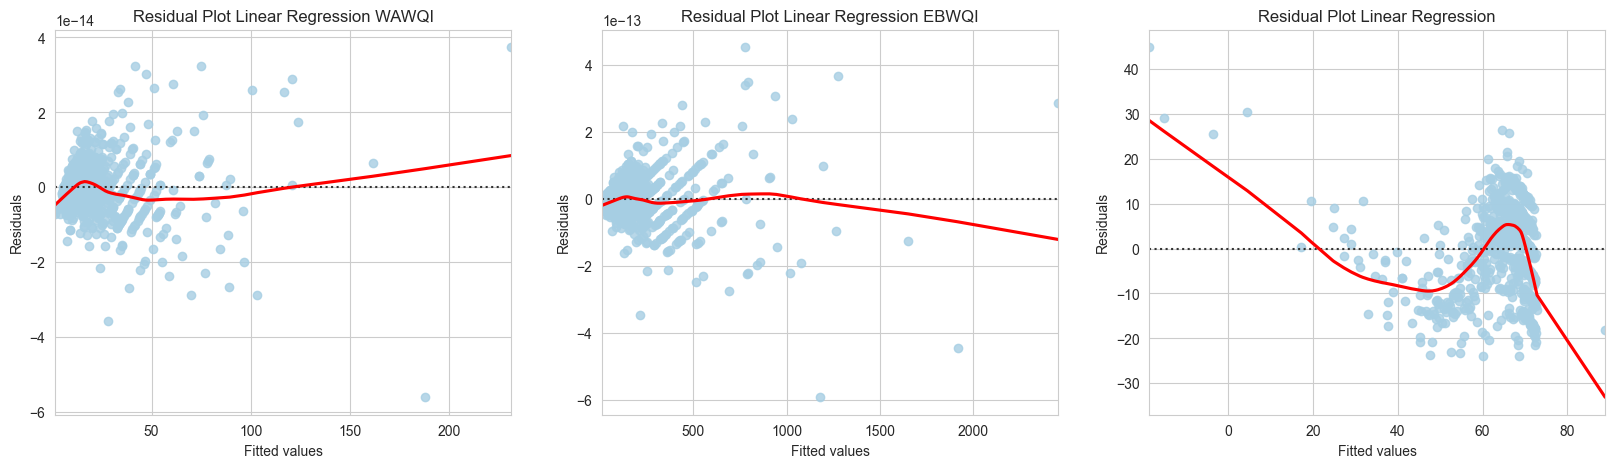

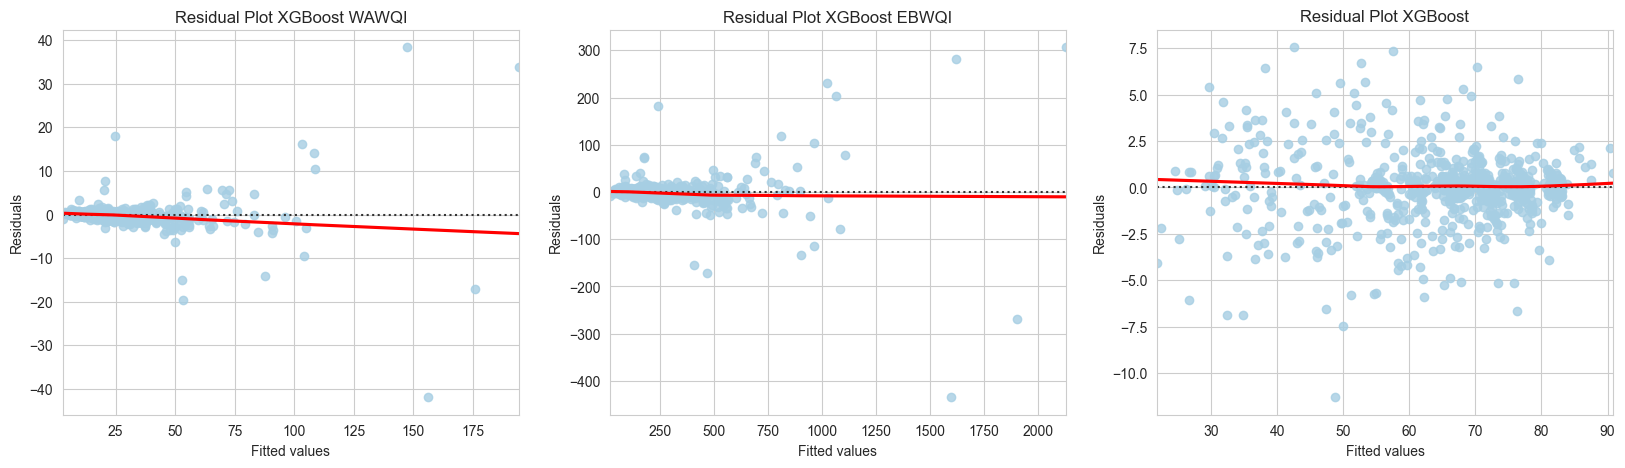

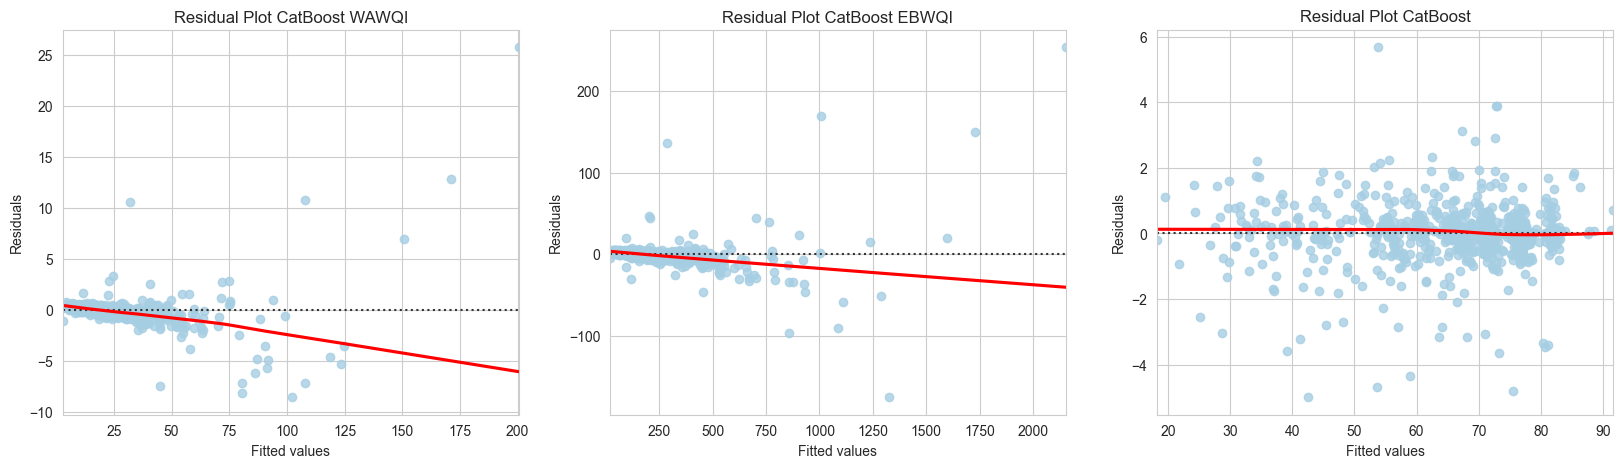

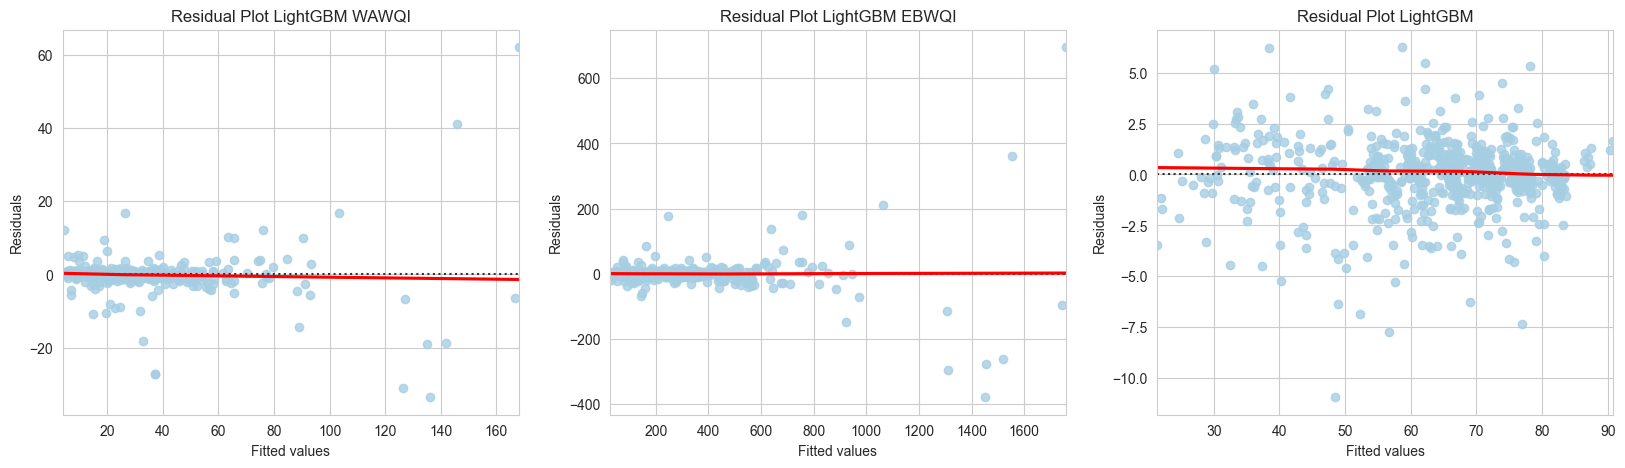

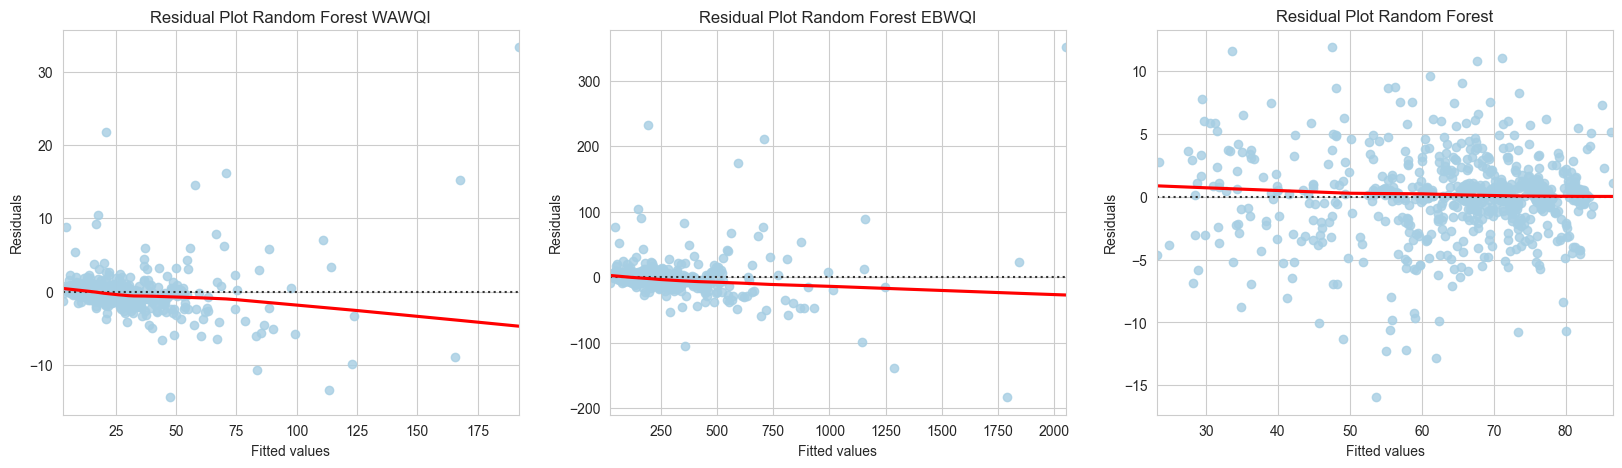

In [25]:
for model in ['Linear Regression', 'XGBoost', 'CatBoost', 'LightGBM', 'Random Forest']:
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for ax, target in zip(axes.flatten(), ['WAWQI', 'EBWQI', 'CCME-WQI']):
        resid_plot_df = regression_results_df[(regression_results_df['Model'] == model) & (regression_results_df['Metric'] == 'R2') & (regression_results_df['Target'] == target)]
        resid_plot_df['residuals'] = resid_plot_df['y_test'] - resid_plot_df['y_pred']
        sns.residplot(x=resid_plot_df['y_pred'].values[0], y=resid_plot_df['residuals'].values[0].values, lowess=True, line_kws={'color': 'red'}, ax=ax)
        ax.set_xlabel("Fitted values")
        ax.set_ylabel("Residuals")
        ax.set_title(f"Residual Plot {model} {target}")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot {model}")

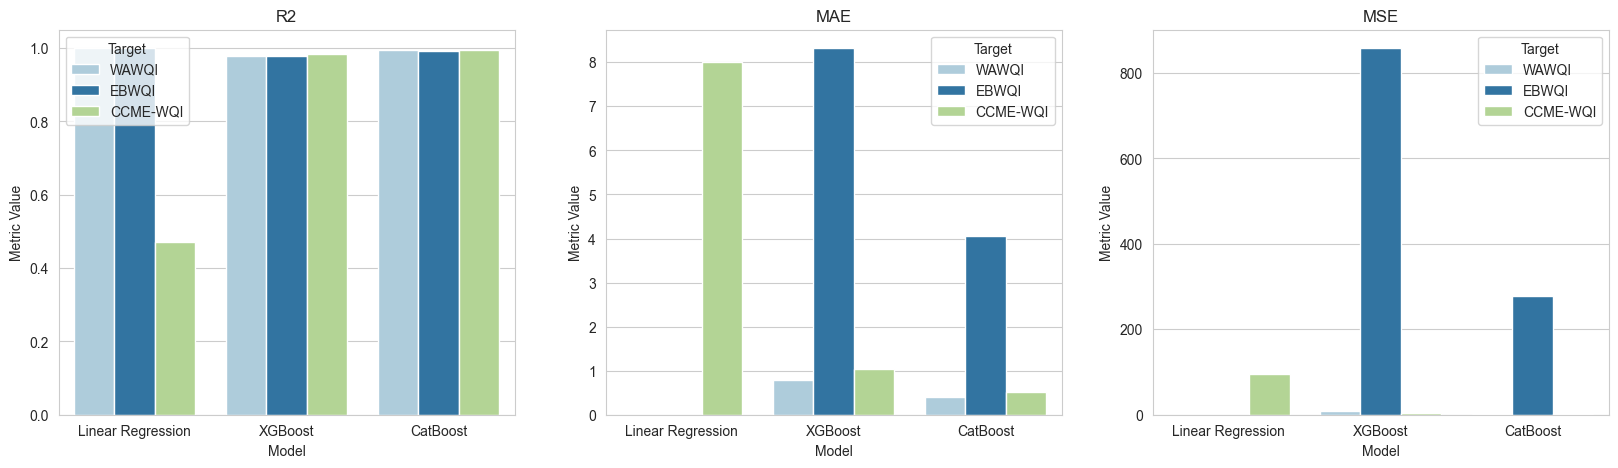

In [26]:
fig, axes = plt.subplots(1,3,figsize=(20,5))

i = 0
ax = axes.flatten()
for metric in ['R2','MAE','MSE']:
        regression_results_df_tmp = regression_results_df[(regression_results_df['Model'].isin(['Linear Regression','XGBoost','CatBoost'])) & (regression_results_df['Metric'] == metric)]
        sns.barplot(data=regression_results_df_tmp, x='Model', y='Metric Value', hue='Target', ax=ax[i])
        ax[i].set_title(f'{metric}')
        i+=1

## :sparkles: Best Models:
### Regression: CatBoost

# :sparkles: Hyperparameter Tuning

In [27]:
X = wqi[features]
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X, columns=features)

# Regression
y1 = wqi['WAWQI']
y2 = wqi['EBWQI']
y3 = wqi['CCME-WQI']

# Train test split
X_train_reg, X_test_reg, y1_train_reg, y1_test_reg, y2_train_reg, y2_test_reg, y3_train_reg, y3_test_reg = train_test_split(X, y1, y2, y3, test_size=0.2, random_state=42)

In [28]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [30]:
from functools import partial

def optimize_catboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(catboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_xgboost():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(xgboost_objective, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

def optimize_randomforest():
    best_params = {}
    for method, y_train, y_test in zip(['WAWQI','EBWQI','CCME-WQI'], [y1_train_reg, y2_train_reg, y3_train_reg], [y1_test_reg, y2_test_reg, y3_test_reg]):
        study_regressor = optuna.create_study(direction='minimize')
        objective_with_args = partial(optimize_randomforest, y_train_reg=y_train, y_test_reg=y_test)
        study_regressor.optimize(objective_with_args, n_trials=10)

        # Print the best parameters found for regressor
        print(f"Best Parameters for Regressor {method}:", study_regressor.best_params)

        # Get the best CatBoost Regressor
        best_catboost_regressor = CatBoostRegressor(**study_regressor.best_params, verbose=0)
        best_catboost_regressor.fit(X_train_reg, y_train)

        # For Regressor
        y_pred_reg = best_catboost_regressor.predict(X_test_reg)

        # Compute mean squared error
        mse_reg = mean_squared_error(y_test, y_pred_reg)
        print(f"Mean Squared Error for Regressor {method}:", mse_reg)

        best_params[method] = study_regressor.best_params
    
    return best_params

In [31]:
best_params_catboost = optimize_catboost()

[I 2024-05-11 19:50:41,575] A new study created in memory with name: no-name-8394b012-fabf-4237-999d-b63c2bd7f2de
